# Customer Churn - Savings Bank - All Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_roc_curve, confusion_matrix, roc_auc_score, f1_score

import warnings
warnings.filterwarnings("ignore")

### Reading in and inspecting data

In [2]:
df = pd.read_csv("../data/Tabla_01_English_Unique_postEDA.csv", index_col=0, parse_dates=True)


In [3]:
df.shape

(4304, 24)

In [4]:
df.head(3)

,Client_ID,Resident_Capital,Client_Age_Years,Client_Sex,Client_Married,Amount_Last_Disbursement,n(Months)_Since_Last_Disbursement,n(Months)_Client_Relationship,n(Months)_LO_Active_Employee,Client_Status_Post3Months,...,n(Loans)_Outstanding_Other,n(Additional_Loans)_Post3Months,n(Additional_Loans)_Post6Months,Total_Accumulated_Interest_per_Client,LO_Active_Employee_Prior3Months,LO_Active_Employee_Prior6Months,n(Additional_Loans)_Pre3Months,n(Additional_Loans)_Pre6Months,LO_Changed,n(Months)_Change_LO
Fecha Cierre,,,,,,,,,,,,,,,,,,,,,
2018-01-31,1090100000183,1,67,1,0,66500.0,57,74,19,1,...,2,0,0,19,1,1,0,0,1,13
2018-01-31,1090100003778,1,59,1,1,22000.0,0,81,45,0,...,1,0,0,127,1,1,1,1,0,0
2018-01-31,1090100003930,1,65,1,0,18000.0,1,31,24,0,...,2,0,0,0,1,1,1,1,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4304 entries, 2018-01-31 to 2021-05-31
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Client_ID                              4304 non-null   int64  
 1   Resident_Capital                       4304 non-null   int64  
 2   Client_Age_Years                       4304 non-null   int64  
 3   Client_Sex                             4304 non-null   int64  
 4   Client_Married                         4304 non-null   int64  
 5   Amount_Last_Disbursement               4304 non-null   float64
 6   n(Months)_Since_Last_Disbursement      4304 non-null   int64  
 7   n(Months)_Client_Relationship          4304 non-null   int64  
 8   n(Months)_LO_Active_Employee           4304 non-null   int64  
 9   Client_Status_Post3Months              4304 non-null   int64  
 10  Client_Status_Post6Months              4304 non-null  

In [6]:
df.columns

Index(['Client_ID', 'Resident_Capital', 'Client_Age_Years', 'Client_Sex',
       'Client_Married', 'Amount_Last_Disbursement',
       'n(Months)_Since_Last_Disbursement', 'n(Months)_Client_Relationship',
       'n(Months)_LO_Active_Employee', 'Client_Status_Post3Months',
       'Client_Status_Post6Months', 'LO_Active_Employee_Post3Months',
       'LO_Active_Employee_Post6Months', 'n(Loans)_Outstanding_Maynas',
       'n(Loans)_Outstanding_Other', 'n(Additional_Loans)_Post3Months',
       'n(Additional_Loans)_Post6Months',
       'Total_Accumulated_Interest_per_Client',
       'LO_Active_Employee_Prior3Months', 'LO_Active_Employee_Prior6Months',
       'n(Additional_Loans)_Pre3Months', 'n(Additional_Loans)_Pre6Months',
       'LO_Changed', 'n(Months)_Change_LO'],
      dtype='object')

## Define X, y and split data (using complete dataset, i.e. years 2018 - may 2021 for fitting and evaluating models).

Note:
- dataset is not very imbalanced, which does not coincide with historic data. Given time restrictions, this (untidy) data set was still used for next analysis
- splitting of data includes only separation into two sets: X_train and X_val; X_test has been provided by SB separately and includes data for months June - August 2021.

In [7]:
X = df.drop(["Client_Status_Post3Months", "Client_Status_Post6Months"], axis=1) # excluding target variables
y = df["Client_Status_Post3Months"]  
X.shape, y.shape

((4304, 22), (4304,))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # no need to stratify (default includes it)

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3443, 22), (3443,), (861, 22), (861,))

### Grid Search for hyperparameter tuning: Random Forest Classifier

In [10]:
model_RF = RandomForestClassifier()

In [11]:
param_grid = {'n_estimators': [5, 10, 25, 50, 100],
              'max_depth': [3, 20],
              'min_samples_split': [2, 3, 5, 10]} 

In [12]:
grid_search = GridSearchCV(model_RF, param_grid, verbose=True, cv=5)

In [13]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 20],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [5, 10, 25, 50, 100]},
             verbose=True)

#### Inspect params

In [14]:
grid_search.best_params_

{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 50}

#### Check if RF model overfits.

In [15]:
rf_best = grid_search.best_estimator_

In [16]:
rf_best.predict(X_val)

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
rf_best.score(X_train, y_train).round(2)

1.0

In [18]:
rf_best.score(X_val, y_val).round(2)

0.93

#### Model overfits with these parameters => further manual tuning till optimal params are found. See below on training the Random Forest model.

### Feature Engineering: scaling - training data

In [19]:
scaler = MinMaxScaler()

In [20]:
Xtrain_scaled = scaler.fit_transform(X_train)

### Feature Engineering: include timestamps - training data

In [21]:
X_train["Year"] = X_train.index.year

In [22]:
X_train["Month"] = X_train.index.month

In [23]:
X_train.columns

Index(['Client_ID', 'Resident_Capital', 'Client_Age_Years', 'Client_Sex',
       'Client_Married', 'Amount_Last_Disbursement',
       'n(Months)_Since_Last_Disbursement', 'n(Months)_Client_Relationship',
       'n(Months)_LO_Active_Employee', 'LO_Active_Employee_Post3Months',
       'LO_Active_Employee_Post6Months', 'n(Loans)_Outstanding_Maynas',
       'n(Loans)_Outstanding_Other', 'n(Additional_Loans)_Post3Months',
       'n(Additional_Loans)_Post6Months',
       'Total_Accumulated_Interest_per_Client',
       'LO_Active_Employee_Prior3Months', 'LO_Active_Employee_Prior6Months',
       'n(Additional_Loans)_Pre3Months', 'n(Additional_Loans)_Pre6Months',
       'LO_Changed', 'n(Months)_Change_LO', 'Year', 'Month'],
      dtype='object')

In [24]:
X_train.shape

(3443, 24)

### Feature Engineering: scaling - validation data

In [25]:
X_val_scaled = scaler.transform(X_val)

### Feature Engineering: include timestamps - validation data

In [26]:
X_val["Year"] = X_val.index.year

In [27]:
X_val["Month"] = X_val.index.month

In [28]:
X_val.columns

Index(['Client_ID', 'Resident_Capital', 'Client_Age_Years', 'Client_Sex',
       'Client_Married', 'Amount_Last_Disbursement',
       'n(Months)_Since_Last_Disbursement', 'n(Months)_Client_Relationship',
       'n(Months)_LO_Active_Employee', 'LO_Active_Employee_Post3Months',
       'LO_Active_Employee_Post6Months', 'n(Loans)_Outstanding_Maynas',
       'n(Loans)_Outstanding_Other', 'n(Additional_Loans)_Post3Months',
       'n(Additional_Loans)_Post6Months',
       'Total_Accumulated_Interest_per_Client',
       'LO_Active_Employee_Prior3Months', 'LO_Active_Employee_Prior6Months',
       'n(Additional_Loans)_Pre3Months', 'n(Additional_Loans)_Pre6Months',
       'LO_Changed', 'n(Months)_Change_LO', 'Year', 'Month'],
      dtype='object')

In [29]:
X_val.shape

(861, 24)

## Fit and evaluate models 

### Fit a Logistic Regression model

In [30]:
# Define weights for cost-sensitive learning.
weights = {0:0.41, 1:0.59}     # rationale: taking inverse distribution of labels (see EDA on distribution of minority/majority groups).


In [31]:
model_LR = LogisticRegression(class_weight = weights, random_state=42) 
model_LR.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.41, 1: 0.59}, random_state=42)

### Make predictions.

In [32]:
ypred_LR = model_LR.predict(X_val)

In [33]:
probs_LR = model_LR.predict_proba(X_val)
probs_LR

array([[0.49769298, 0.50230702],
       [0.49769277, 0.50230723],
       [0.49769277, 0.50230723],
       ...,
       [0.49769235, 0.50230765],
       [0.49769298, 0.50230702],
       [0.49769298, 0.50230702]])

### Evaluate LogReg: ROC curve 

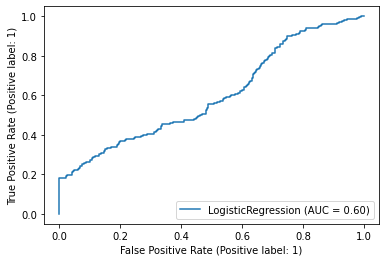

In [34]:
model_LR_disp = plot_roc_curve(model_LR, X_val, y_val)
plt.show()

### Evaluate LogReg: confusion matrix and AUC

In [35]:
print(f"Confusion Matrix: \n{confusion_matrix(y_val, ypred_LR)}")
print(f"Area Under Curve: {roc_auc_score(y_val, ypred_LR).round(2)}")
print(f"f1 - score: {f1_score(y_val, ypred_LR).round(2)}")

Confusion Matrix: 
[[  0 529]
 [  0 332]]
Area Under Curve: 0.5
f1 - score: 0.56


Interpretation:
- TP = 0, i.e. model does not make any predictions re positive class. First indication that model underperforms.

In [36]:
auc_LR = roc_auc_score(y_val, ypred_LR)
f1_LR = f1_score(y_val, ypred_LR)

Interpretation:
- AUC = 0.50, i.e. we don't need to build any model => we could "toss a coin" instead
- Model underperforms, which COULD have to do with outliers...LogReg is sensitive to outliers => model would have to be run again in future, but excluding outliers.

### Fit a Random Forest model

In [37]:
model_RF = RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=63, random_state=42) # params from manual tuning

In [38]:
X_train.copy()
y_train.copy()

Fecha Cierre
2018-07-31    0
2018-06-30    0
2018-07-31    0
2021-04-30    1
2019-01-31    1
             ..
2020-09-30    1
2018-02-28    1
2020-04-30    1
2021-02-28    1
2018-04-30    1
Name: Client_Status_Post3Months, Length: 3443, dtype: int64

In [39]:
model_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=63,
                       random_state=42)

### Make predictions.

In [40]:
ypred_RF = model_RF.predict(X_val)


In [41]:
probs_RF = model_RF.predict_proba(X_val) 
probs_RF

array([[0.95030608, 0.04969392],
       [0.03777318, 0.96222682],
       [0.96217083, 0.03782917],
       ...,
       [0.92207349, 0.07792651],
       [0.01819017, 0.98180983],
       [0.02745106, 0.97254894]])

### Evaluate Random Forest: ROC curve 

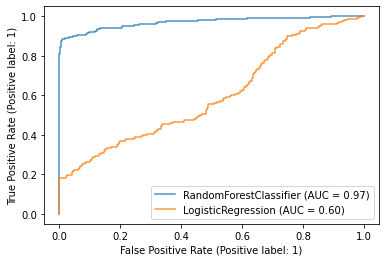

In [42]:
ax = plt.gca()

model_RF_disp = plot_roc_curve(model_RF, X_val, y_val, ax=ax, alpha=0.8)
model_LR_disp.plot(ax=ax, alpha=0.8)

plt.show() 

### Evaluate Random Forest: confusion matrix and AUC

In [43]:
print(f"Confusion Matrix: \n{confusion_matrix(y_val, ypred_RF)}")
print(f"Area Under Curve: {roc_auc_score(y_val, ypred_RF).round(2)}")
print(f"f1 - score: {f1_score(y_val, ypred_RF).round(2)}")

Confusion Matrix: 
[[516  13]
 [ 36 296]]
Area Under Curve: 0.93
f1 - score: 0.92


In [44]:
auc_RF = roc_auc_score(y_val, ypred_RF)
f1_RF = f1_score(y_val, ypred_RF)

Interpretation:
- re Confusion Matrix: out of 332 predictions regarding the positive class, 89% were predicted correctly. Out of 529 predictions regarding the negative class, only 2% were predicted incorrectly (false negatives).
- f1 - score:  93%
- re AUC: the likelihood that a randomly selected customer from the minority group is scored higher than the a randomly selected customer from the majority group is 94% in the case of a RandomForest classifier (vs. 50% of a LogReg classifier).

### Fit a Decision Tree model

In [45]:
model_DT = DecisionTreeClassifier(max_depth=6, random_state=42) # param from manual tuning

In [46]:
X_train.copy()
y_train.copy()

Fecha Cierre
2018-07-31    0
2018-06-30    0
2018-07-31    0
2021-04-30    1
2019-01-31    1
             ..
2020-09-30    1
2018-02-28    1
2020-04-30    1
2021-02-28    1
2018-04-30    1
Name: Client_Status_Post3Months, Length: 3443, dtype: int64

In [47]:
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

### Make predictions.

In [48]:
ypred_DT = model_DT.predict(X_val)

In [49]:
probs_DT = model_DT.predict_proba(X_val)
probs_DT

array([[0.97474747, 0.02525253],
       [0.06393678, 0.93606322],
       [0.97474747, 0.02525253],
       ...,
       [0.99726776, 0.00273224],
       [0.06393678, 0.93606322],
       [0.06393678, 0.93606322]])

### Evaluate Decision Tree: ROC curve 

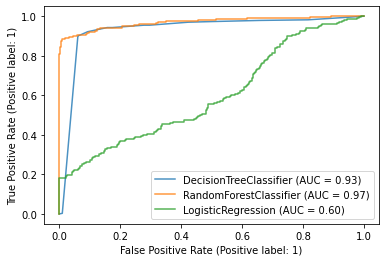

In [50]:
ax = plt.gca()

model_DT_disp = plot_roc_curve(model_DT, X_val, y_val, ax=ax, alpha=0.8)
model_RF_disp.plot(ax=ax, alpha=0.8)
model_LR_disp.plot(ax=ax, alpha=0.8)

plt.show()

### Evaluate Decision Tree: confusion matrix and AUC

In [51]:
print(f"Confusion Matrix: \n{confusion_matrix(y_val, ypred_DT)}")
print(f"Area Under Curve: {roc_auc_score(y_val, ypred_DT).round(2)}")
print(f"f1 - score: {f1_score(y_val, ypred_DT).round(2)}")

Confusion Matrix: 
[[495  34]
 [ 32 300]]
Area Under Curve: 0.92
f1 - score: 0.9


In [52]:
auc_DT = roc_auc_score(y_val, ypred_DT)
f1_DT = f1_score(y_val, ypred_DT)

Interpretation:
- re Confusion Matrix: out of 332 predictions regarding the positive class, 90% were predicted correctly. As such, DT shows best precision of all models. Out of 529 predictions regarding the negative class, 6% were predicted incorrectly (false negatives). 
- f1 - score = 89.95% 
- re AUC: the likelihood that a randomly selected customer from the minority group is scored higher than the a randomly selected customer from the majority group is 92% in the case of a Decision Tree classifier (vs. 94% of a Random Forest classifier).

### Summary model evaluation: AUC

In [53]:
auc = [["LogReg", auc_LR], ["Tree",  auc_DT], ["RF",  auc_RF]]
auc  = pd.DataFrame(auc , columns = ["Model", "auc"])
auc.sort_values(by=["auc"], inplace=True, ascending = False)
auc

,Model,auc
2,RF,0.933496
1,Tree,0.919671
0,LogReg,0.500000


### Summary model evaluation: f1 - score

In [54]:
f1 = [["LogReg", f1_LR], ["Tree",  f1_DT], ["RF",  f1_RF]]
f1  = pd.DataFrame(f1 , columns = ["Model", "f1"])
f1.sort_values(by=["f1"], inplace=True, ascending = False)
f1

,Model,f1
2,RF,0.923557
1,Tree,0.900901
0,LogReg,0.556580


#### Interpretation
* Random Forest Model shows best performance (based on AUC and f1-score).

## Checking for feature importance using random forest regressor. Using two different approaches ("mean decrease in impurity" and "feature permutation").

##### Feature importance based on mean decrease in impurity (based on https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [55]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])] 

In [56]:
importances = model_RF.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in model_RF.estimators_], axis=0)

In [57]:
type(importances)

numpy.ndarray

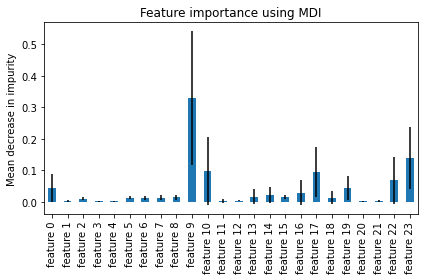

In [58]:
model_RF_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
model_RF_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [59]:
pd.DataFrame({'importance': model_RF.feature_importances_, 'feature': X_train.columns}).\
sort_values('importance', ascending=False)

,importance,feature
9,0.329840,LO_Active_Employee_Post3Months
23,0.139761,Month
10,0.098888,LO_Active_Employee_Post6Months
17,0.095390,LO_Active_Employee_Prior6Months
22,0.068920,Year
0,0.044914,Client_ID
19,0.042808,n(Additional_Loans)_Pre6Months
16,0.029431,LO_Active_Employee_Prior3Months
14,0.021491,n(Additional_Loans)_Post6Months
13,0.016828,n(Additional_Loans)_Post3Months


#### Interpretation
* Clearly: relationship between customers and advisors (here: "Loan Officers", or "LO") matters! If the LO has left prior to (or after) the cutoff date will determining for likelihood if customer  will have left (or not) the Savings Bank 3 months later. If LO leave after 3 months, likelihood that clients will also leave is higher than in LO leave 6 months later.  
* It's interesting to see that time variables also play a relatively important role for predicting churn. Given the relative importance of the features "month" and "year", it can be expected that churn has a seasonality component (indicating that time series analysis could lead to additional insights).
* Financial aspects, such as number of additional loans or outstanding amounts with the Savings Bank do not contribute to estimating likelihood of the customer leaving the Savings Bank 3 months later.
* It doesn't make sense that Client ID ranks so high...most probably, this has to do with duplicates which have not been extracted yet.

##### Feature importance based on feature permutation (based on https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [60]:
result = permutation_importance(
    model_RF, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2)

model_RF_importances = pd.Series(result.importances_mean, index=feature_names)

importances = model_RF.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in model_RF.estimators_], axis=0)

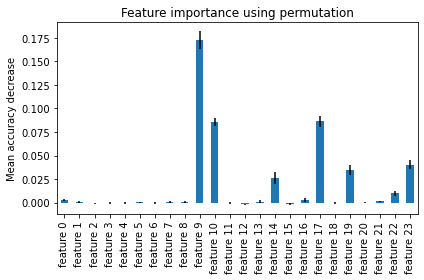

In [61]:
fig, ax = plt.subplots()
model_RF_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importance using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [62]:
pd.DataFrame({'importance': model_RF_importances, 'feature': X_train.columns}).\
sort_values('importance', ascending=False)

,importance,feature
feature 9,0.172706,LO_Active_Employee_Post3Months
feature 17,0.086411,LO_Active_Employee_Prior6Months
feature 10,0.086063,LO_Active_Employee_Post6Months
feature 23,0.040302,Month
feature 19,0.034959,n(Additional_Loans)_Pre6Months
feature 14,0.026365,n(Additional_Loans)_Post6Months
feature 22,0.009756,Year
feature 16,0.002671,LO_Active_Employee_Prior3Months
feature 0,0.002671,Client_ID
feature 21,0.001394,n(Months)_Change_LO


#### Interpretation
* Similar results to above: if LO leaves after 3/6 months, likelihood that client will churn will be relatively high. Note also importance of timestamps for predicting churn.  